In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import UnivariateSpline

In [2]:
((0.87+0.670)/2)*2.355

1.81335

In [3]:
#SOME CONSTANTS

dgrid=np.arange(0.5, 10, 0.2)
BEST_BW=0.7
#dgrid
THEORITICAL_STREAM_WIDTHS={'10_20': 0.053, '30_40': 0.094, '50_60':1.53}
GAP_SIZES={'10_20': 1.4, '30_40': 2.5, '50_60': 1.8}

In [4]:
def read_backgrounds_file(m, rgc):
    
    fls= glob.glob('../data/backgrounds/*rgc{}*maglimit{}*'.format(rgc, m))
    
    res=[]
    for f in fls:
        #print (f)
        c=np.load(f, allow_pickle=True)
        for vls in c:
            #print (vls)
            dct={}
            for k in list(vls.keys()):
                dct['dmod']=float(k.split('galaxy')[-1])
                dct['run']=f.split('run')[-1].split('.npy')[0]
                for ks in (vls[k].keys()):
                    dct[ks]=vls[k][ks]
                    
                data= vls[k]['data']
                area= (data[0].max()-data[0].min())*(data[1].max()-data[1].min())
                dct['density']= len(data[0])/area
                dct['area']=area
                dct['counts']=len(data[0])
                res.append(dct)
               
    
    return pd.DataFrame(res)


In [5]:
#3=2

In [6]:
#functions
def show_gap_detection(vld,  GAP_SIZE, plot='None', ax=None, alpha=0.1, ms=0.1):
        #define stuff 
        meshgrid= vld['meshgrid']
        data=vld['data']
        
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),90 ) 
        stream_mask= vld['min_eigen'] < np.percentile(vld['min_eigen'].flatten(),15)
        
        #define weights as the density inside the stream
        #weights= 
        
        if np.isnan( vld['min_eigen']).all():
            return {}
        
        stream_size=1.0*np.nanstd(meshgrid[1][stream_mask])

        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])


        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
        #redefine the stream track as a check (just a random place at 0.5 pc from the center)

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2,
                                        stream_track])
        #gap_track= np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2

       
        
        data_df=pd.DataFrame()
        data_df['x']=data[:,0]
        data_df['y']=data[:,1]
        
        grid_df=pd.DataFrame()
        grid_df['x']= grid_data[:,0]
        grid_df['y']= grid_data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and(np.abs((data[:,0]-gap_center[0])) <GAP_SIZE/2,  stream_track_on_data)

        nstars_stream=len( data_df[stream_track_on_data])
        nstars_bck=len( data_df[~stream_track_on_data])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        stream_area=10*len( grid_df[stream_track])/len(grid_df)
        bck_area=10*len( grid_df[~stream_track])/len(grid_df)
        gap_area=10*len(grid_df[gap_track])/len(grid_df)
        
         #compute relevant statistics
        gap_offset=5
        try:
            gap_offset=np.nanmedian(np.abs(meshgrid[0][gap_mask]-np.nanmedian(meshgrid[0])))
        except:
            pass
        
        stats={'spread_stream_stars_x': np.nanstd(meshgrid[0][stream_mask]),
               'spread_stream_stars_y': np.nanstd(meshgrid[1][stream_mask]),
              'spread_gap_stars_x': np.nanstd(meshgrid[0][gap_mask]),
            'spread_gap_stars_y':np.nanstd(meshgrid[1][gap_mask]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_area': stream_area,
               'gap_area': gap_area,
               'bck_area': bck_area,
               'stream_dens':  np.divide(nstars_stream, stream_area),
               'gap_dens': np.divide(nstars_gap, gap_area),
               'bck_dens':np.divide(nstars_bck, bck_area),
               'offset_center':gap_offset,
               'gap_center': np.nanmedian(grid_data[:,0][gap_track]),
               'gap_points':grid_data[:,0][gap_track],
               'stream_center': np.nanmedian(grid_data[:,1][stream_track]),
               'stream_points':grid_data[:,1][stream_track],
              }

        if plot=='show_mask_data':
            ax.scatter(data_df.x, data_df.y,  s=10, alpha=0.1, c='k')
            ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
            ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')
        
        if plot=='show_mask_grid':
            ax.scatter(grid_df.x, grid_df.y,  s=1, alpha=1, c='k')
            ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
        
        if plot=='plot0':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=10, alpha=alpha, c='k')
            
        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=0.5, vmin=0, vmax=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, vmin=0.0, vmax=0.2, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=ms, alpha=alpha, c='k')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        if plot=='plot3':
            #verify by plotting
            #ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=alpha, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
        if plot=='plot7':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.scatter(np.nanmedian(grid_data[:,0][gap_track]), \
                       np.nanmax(vld['meshgrid'][1])-0.5, color='k', marker='$\u2193$', s=100)
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
        if plot=='density':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            p= ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')

       
        return stats


In [7]:
#f.split('rgc')[-1].split('_mhalo')[0]

In [8]:
#plt.hist(df.spread_stream_stars.values)

In [9]:
#vls=[]
#for i in range(0, 1000):
#    x=show_gap_detection(v)
#    x['trial']= i
#    vls.append(x)
    
#dx=pd.DataFrame(vls)

In [10]:
#dx

In [11]:
#plt.hist(dx.gap_dens/dx.stream_dens)
from tqdm import tqdm

In [12]:
df = pd.DataFrame()
for f in tqdm(glob.glob('../data/pipeline/*.npy')):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            #for i in range(0, 10):
            rgc=f.split('rgc')[-1].split('_mhalo')[0]
            r=pd.Series(show_gap_detection(vls[k],  GAP_SIZES[rgc]))#, ax=ax, plot='plot3'))

            r['rgc']=rgc
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            #r['trial']=i


            df=df.append(r, ignore_index=True )





100%|█████████████████████████████████████████| 675/675 [14:23<00:00,  1.28s/it]


In [13]:
df['distance']=10**((df.dmod.values/5)+1)

In [14]:
10**((24.52/5)+1)

801678.0633876789

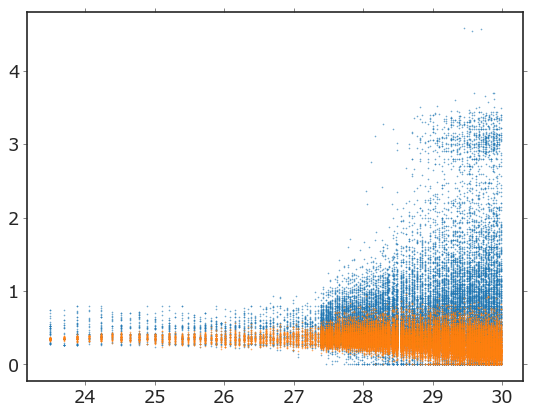

In [15]:
#am i COMPUTING THE AREA WRONG? COMPARE GAP AREA TO STREAM_WIDTH X GAP SIZE SHOULD BE AT LEAST WITHIN AN ORDER OF M
#MAGNITUDE
fig, ax=plt.subplots()
ax.scatter(df.dmod[df.bw==0.7], df.gap_area[df.bw==0.7], s=.1)
ax.scatter(df.dmod[df.bw==0.7], df.spread_stream_stars_y[df.bw==0.7]*GAP_SIZES['10_20'], s=.1)
#ax.set(ylim=[0.,0.5])

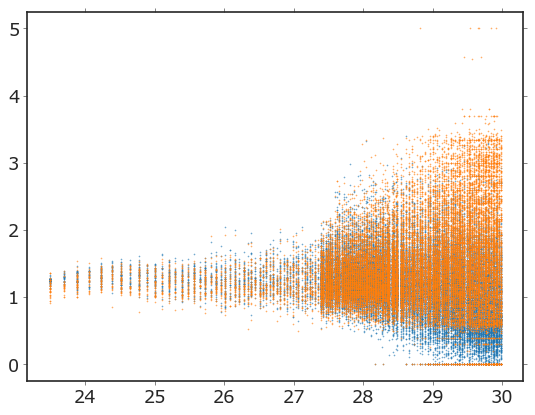

In [16]:
fig, ax=plt.subplots()
ax.scatter(df.dmod[df.bw==0.7], df.spread_stream_stars_y[df.bw==0.7]*5, s=.1)
ax.scatter(df.dmod[df.bw==0.7], df.stream_area[df.bw==0.7], s=.1)

In [17]:
df['rgcx']=df.rgc.apply(lambda x: int(np.nanmedian(np.array(x.split('_')).astype(float))))

In [18]:
#df.gap_points

In [19]:
rgcs=['10_20', '30_40', '50_60']
mag_limits=[27.15, 28.69]

colors={'10_20': '#0074D9',
       '30_40': '#111111',
        
       '50_60': '#FF851B' }

pairs=[x for x in list(itertools.product(rgcs, mag_limits)) ]
#combinations
pairs

[('10_20', 27.15),
 ('10_20', 28.69),
 ('30_40', 27.15),
 ('30_40', 28.69),
 ('50_60', 27.15),
 ('50_60', 28.69)]

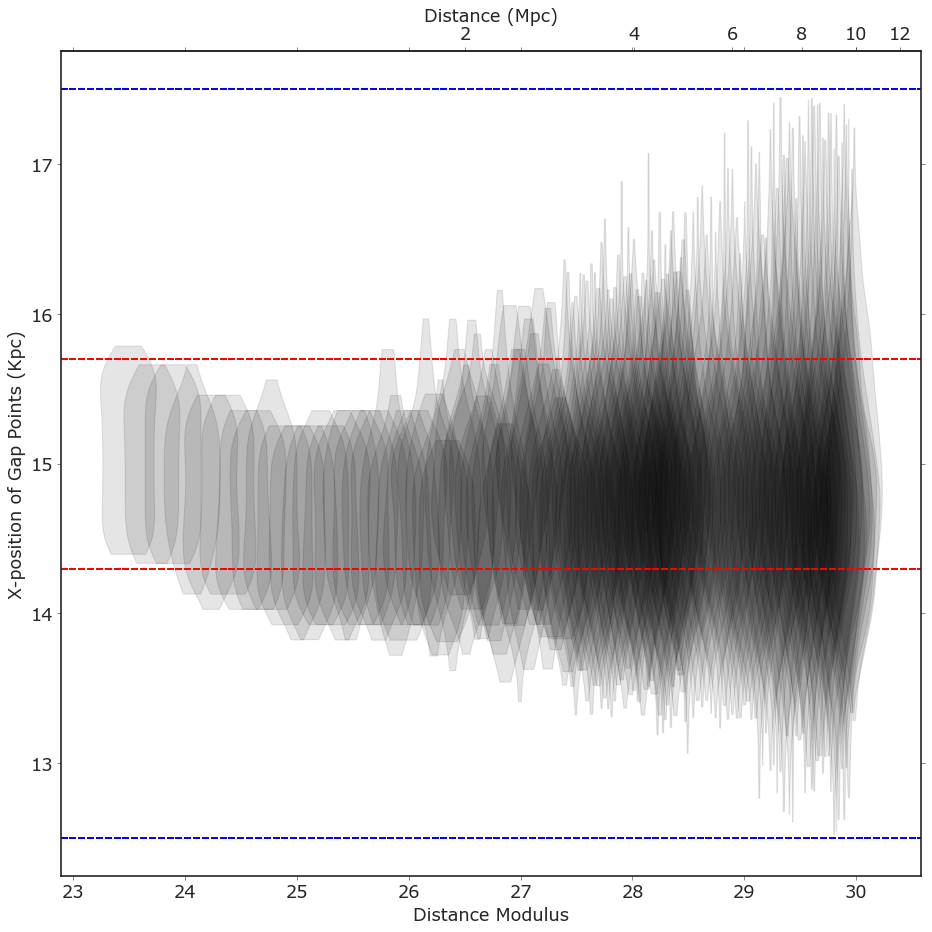

In [20]:
#fig, ax=plt.subplots(ncols=10, nrows=14, figsize=(20, 20))


df_small= (df[np.logical_and.reduce([df.bw==0.7, df.rgc=='10_20', df.mag_limit==28.69])]).reset_index(drop=True)
fig, ax=plt.subplots(figsize=(12, 12))
for g in df_small.groupby('dmod'):
    #compute median and standard devidation
    
    gpnts=g[1].gap_points.values
    
    for i in range(len(gpnts)):
        med= np.nanmedian(gpnts[i])
        std= np.nanstd(gpnts[i])
        x=np.nanmedian(g[1].dmod)
        #ax.errorbar(x, med, fmt='*', c=colors['10_20'], alpha=1.)
    
    
    #ax.plot(x, med, color=colors['10_20'], linewidth=3)

    
    
    xvals=[x for i in np.concatenate(g[1].gap_points.values)]
    
    #ax.scatter(xvals,np.concatenate(g[1].gap_points.values), c='k', marker='.', alpha=0.1, s=200)
    #bp = ax.boxplot(np.concatenate(g[1].gap_points.values), positions=[np.nanmedian(g[1].dmod)])
    vion = ax.violinplot(np.concatenate(g[1].gap_points.values), positions=[np.nanmedian(g[1].dmod)],
                     showmedians=False, showextrema=False, showmeans=False)
    
    
    for pc in vion['bodies']:
        pc.set_facecolor('black')
        pc.set_edgecolor('black')
        pc.set_alpha(0.1)

    ax.axhline(15-2.5, linestyle='--', c='b')
    ax.axhline(15+2.5, linestyle='--', c='b')
    
    ax.axhline(15-GAP_SIZES['10_20']/2, linestyle='--', c='r')
    ax.axhline(15+GAP_SIZES['10_20']/2, linestyle='--', c='r')
    #_=plt.hist(np.concatenate(g[1].gap_points.values), bins=32)
_= ax.set(ylabel='X-position of Gap Points (Kpc)', xlabel='Distance Modulus')

def forward(x):
    return (10**((x/5)+1))/1e6

def inverse(x):
    return  5*np.log10(x*1000/(10))

secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set(xlabel='Distance (Mpc)')

#a.set( xlabel='Distance Modulus', ylabel='Bandwidth (kpc)', ylim=[0.05, 1.65], xlim=[23.7, 29.35])

plt.tight_layout()
plt.savefig('../figures/gap_points_diagnostics.jpeg')

In [21]:
#ax.violinplot?

In [22]:
import itertools

In [23]:
df=df.reset_index(drop=True)

In [24]:
bckd=read_backgrounds_file(28.69, '10_20')
bckd.columns

Index(['dmod', 'run', 'rgc', 'mag_limit', 'data', 'density', 'area', 'counts'], dtype='object')

In [25]:
def get_median(x):
    if len(x)<1:
        return np.nan
    else:
        return np.nanmedian(x)
    
def get_std(x):
    if len(x)<1:
        return np.nan
    else:
        return np.nanstd(x)

In [26]:
def get_counts(df, dgrid, rgc, m):
    
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    bools=np.logical_and.reduce([(df.bw==BEST_BW).values,\
                                 (df.rgc==rgc).values,
                                 (df.mag_limit==m).values])
    
    bckd=read_backgrounds_file(m, rgc)
    bckd['distance']=10**((bckd.dmod.values/5)+1)
    
    #print (bools)
    df0=(df[bools]).reset_index(drop=True)
    #jkl
    res={'gap_dens':[],
         'stream_dens':[],
         'bck_dens':[],
         'gap_stream_ratio':[],
         'stream_bck_ratio':[],
         'gap_bck_ratio':[],
         'st_error_percent':[],
         'gp_error_percent':[],
         'bck_error_percent':[],
         'gp_snr':[],
         'str_snr':[],
         'gap_spread':[],
         'median_gaploc':[],
         'median_treamloc':[],
         'gp_minus_bck_str_minus_bck':[],
         'gp_minus_bck':[],
         'std_gaploc':[],
         'med_gaploc':[],
         'std_streamloc':[],
         'fr_out_gap':[],
         'range_gap_gapsize_ratio':[],
         'gap_area_over_true_area':[],
         'ds': dgrid}
    
    for idx in range(len(dgrid)-1):
        v=df0[np.logical_and(df0.distance/1e6>=dgrid[idx], df0.distance/1e6<dgrid[idx+1])]
        
        vbck=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        
        st, st_err=  np.nanmedian(v.stream_dens.values),  np.nanstd(v.stream_dens.values)
        gp, gp_err=  np.nanmedian(v.gap_dens.values),  np.nanstd(v.gap_dens.values)
        bck, bck_err=  np.nanmedian(vbck.density.values), np.nanstd(vbck.density.values)
        
        #densities
        res['stream_dens'].append([st, st_err])
        res['gap_dens'].append([gp, gp_err])
        res['bck_dens'].append([bck, bck_err])

        stream_bck_ratio=st/bck
        gap_bck_ratio= gp/bck
        gap_st_ratio= gp/st
        #errors
        stream_bck_ratio_er= ((st_err/st)**2+ (bck_err/bck)**2)**0.5
        gap_bck_ratio_er= ((gp_err/gp)**2+ (bck_err/bck)**2)**0.5
        gap_st_ratio_er= ((gp_err/gp)**2+ (st_err/st)**2)**0.5
        
        res['gap_stream_ratio'].append([gap_st_ratio,gap_st_ratio_er])
        res['gap_bck_ratio'].append([gap_bck_ratio,gap_bck_ratio_er])
        res['stream_bck_ratio'].append([stream_bck_ratio,stream_bck_ratio_er])

        
    
        res['st_error_percent'].append([st_err/st, 0.])
        res['gp_error_percent'].append([gp_err/gp, 0])
        res['bck_error_percent'].append([bck_err/bck, 0])
        
        res['gp_minus_bck_str_minus_bck'].append([(gp-bck)/(st-bck), 0])
        res['gp_minus_bck'].append([gp-bck, 0])
        
        
        cs= v.gap_points.values
    
        csx=[]
        
        if len(cs)>0:
            csx=np.concatenate([x for x in cs if len(x)>0])
    
            diffs=np.abs(csx-rgcx)
            med= np.nanmedian(diffs)
            std=np.nanstd(diffs)
            fr= len(diffs[np.abs(diffs>0.5*GAP_SIZES[rgc])])/len(diffs)
            
            res['fr_out_gap'].append([fr, 0])
            res['range_gap_gapsize_ratio'].append([std/GAP_SIZES[rgc], 0])
            res['std_gaploc'].append([std, 0])
            res['med_gaploc'].append([med, 0])
        else:
            res['fr_out_gap'].append([np.nan, 0])
            res['range_gap_gapsize_ratio'].append([np.nan, 0])
            res['std_gaploc'].append([np.nan, 0])
            res['med_gaploc'].append([np.nan, 0])
            
        
            

    return res

In [27]:
def make_line_plot(ax, x, y, yerr, rgc, show_error=False, **kwargs):
    
    nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    #print (vls)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    y1 = np.interp(dgrid, x, y) 
    dy1 = np.interp(dgrid, x, y-yerr)
    dy2 = np.interp(dgrid, x, y+yerr)
    
    ax.plot(dgrid, y1, **kwargs)
    
    if show_error:
        ax.fill_between(dgrid, dy1, dy2, alpha=0.1, color=colors[rgc])
    

    #ax.fill_between(x[~nans], y[~nans]-yerr[~nans], y[~nans]+yerr[~nans],  alpha=0.1, color=colors[rgc])
    
    #ax.plot(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    #ax[0][0].fill_between(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0]-np.vstack(vls['stream_dens'])[:,1],
    #                    np.vstack(vls['stream_dens'])[:,0]+np.vstack(vls['stream_dens'])[:,1], alpha=0.1,\
    #                      color=colors[rgc])

In [28]:
#df

In [29]:
#df.gap_center

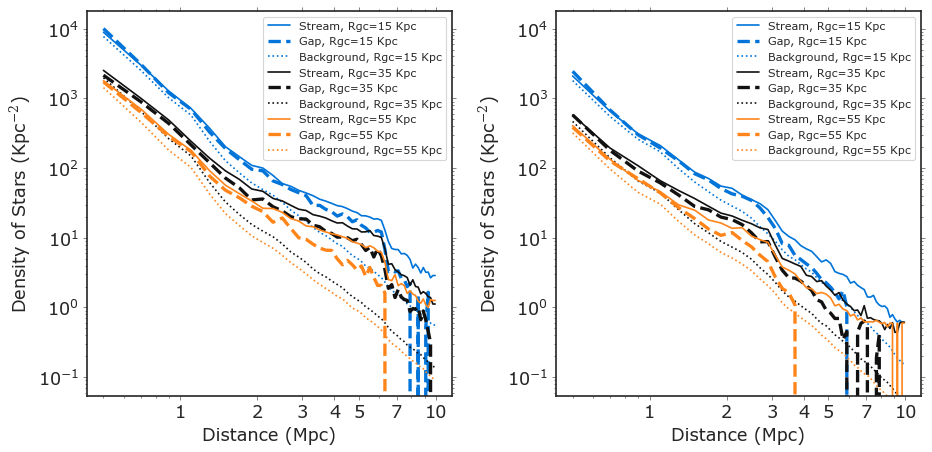

In [30]:
fig, ax=plt.subplots(figsize=(12, 6), ncols=2,  sharey='row')#, height_ratios=[1.,  0.5])

for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[0], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    
    #make_line_plot(ax[1], dgrid[:-1], np.vstack(vls['gap_bck_ratio'])[:,0], np.vstack(vls['gap_bck_ratio'])[:,1],\
    #               rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))

  
    vls=get_counts(df, dgrid,rgc, 27.15)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[1], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[1], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[1], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    

    
    #make_line_plot(ax[1][1], dgrid[:-1], np.vstack(vls['gap_bck_ratio'])[:,0], np.vstack(vls['gap_bck_ratio'])[:,1],\
    #               rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))

    
    
   

for a in ax:
    a.minorticks_on()
    a.set(xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')

for a in ax:
    a.legend(fontsize=10)
    a.set(yticks=10**np.array([-1., 0, 1., 2, 2., 3, 4]))
    a.yaxis.set_tick_params(labelbottom=True)
    a.set(yscale='log', ylabel='Density of Stars (Kpc$^{-2}$)')


#for a in ax[-1]:
#    a.legend(fontsize=10)
    #a.axhline(0.5, linestyle='-', color='k', alpha=0.5, linewidth=3)
    #a.axhline(0.25, linestyle='-', color='k', alpha=0.5, linewidth=3)
    
    # a.axhline(GAP_SIZE, linestyle='--', color='k', alpha=0.5, linewidth=3)
    #a.axhline(GAP_SIZE/2, linestyle='--', color='k', alpha=0.5, linewidth=3)
    #a.text(1, GAP_SIZE+0.05, 'Gap Size', fontsize=14)
    #a.text(1, GAP_SIZE/2+0.05, 'Gap Size/2', fontsize=14)
    
    #a.set(ylabel='Fraction Oustide Gap Region')
    #a.set(yticks=[0.1,0.25,  0.5, 0.75, 1.])
#    plt.setp(a.get_xticklabels(), visible=True)
#    a.yaxis.set_tick_params(labelbottom=True)


#ax[1][0].set(ylim=[-2, 2])
#ax[1][1].set(ylim=[-2, 2])
plt.tight_layout()

plt.savefig('../figures/gap_density_errors_alt.pdf')

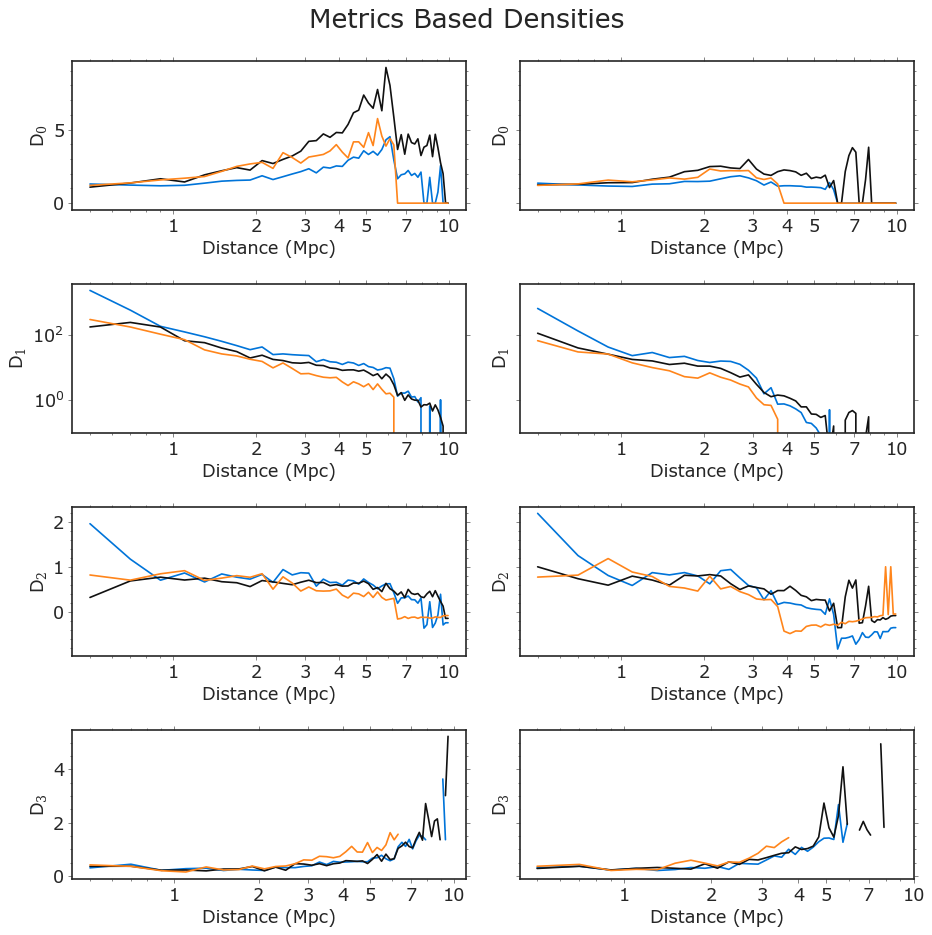

In [32]:
#metrics based on densities
fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=4, sharey='row')#, height_ratios=[1.,  0.5])

for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['gap_bck_ratio'])[:,0], np.vstack(vls['gap_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[1][0], dgrid[:-1], np.vstack(vls['gp_minus_bck'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[2][0], dgrid[:-1], np.vstack(vls['gp_minus_bck_str_minus_bck'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    

    make_line_plot( ax[3][0], dgrid[:-1], np.vstack(vls['gp_error_percent'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))

    vls=get_counts(df, dgrid,rgc, 27.15)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['gap_bck_ratio'])[:,0], np.vstack(vls['gap_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[1][1], dgrid[:-1], np.vstack(vls['gp_minus_bck'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[2][1], dgrid[:-1], np.vstack(vls['gp_minus_bck_str_minus_bck'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    

    make_line_plot( ax[3][1], dgrid[:-1], np.vstack(vls['gp_error_percent'])[:,0], np.vstack(vls['gp_minus_bck'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))


    
for a in np.concatenate(ax):
    a.minorticks_on()
    a.set(xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')


for idx in range(len(ax)):
    ax[idx][0].set(ylabel=r'D$_{}$'.format(idx))
    ax[idx][1].set(ylabel=r'D$_{}$'.format(idx))
    
for a in ax[1]:
    a.set(yscale='log')

    
for a in ax[-1]:
    a.set(yscale='log')

fig.suptitle('Metrics Based Densities', fontsize=24)

plt.tight_layout()

plt.savefig('../figures/metrics_densities.pdf')


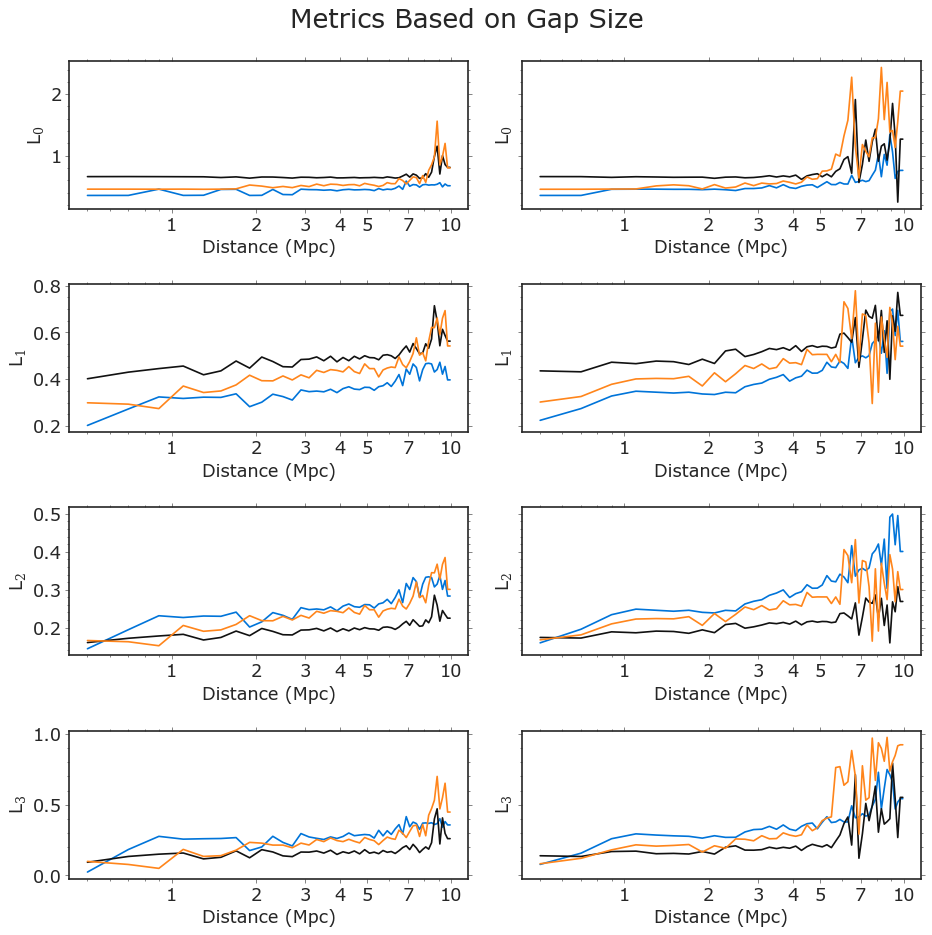

In [33]:
#metrics based on location

fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=4, sharey='row')#, height_ratios=[1.,  0.5])
for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['med_gaploc'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[1][0], dgrid[:-1], np.vstack(vls['std_gaploc'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
 
    make_line_plot( ax[2][0], dgrid[:-1], np.vstack(vls['range_gap_gapsize_ratio'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[3][0], dgrid[:-1], np.vstack(vls['fr_out_gap'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    vls=get_counts(df, dgrid,rgc, 27.15)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['med_gaploc'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[1][1], dgrid[:-1], np.vstack(vls['std_gaploc'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
 
    make_line_plot( ax[2][1], dgrid[:-1], np.vstack(vls['range_gap_gapsize_ratio'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[3][1], dgrid[:-1], np.vstack(vls['fr_out_gap'])[:,0], np.vstack(vls['med_gaploc'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Rgc={} Kpc'.format(rgcx))
    
for a in np.concatenate(ax):
    a.minorticks_on()
    a.set(xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')


for idx in range(len(ax)):
    ax[idx][0].set(ylabel=r'L$_{}$'.format(idx))
    ax[idx][1].set(ylabel=r'L$_{}$'.format(idx))
    

fig.suptitle('Metrics Based on Gap Size', fontsize=24)

plt.tight_layout()


plt.savefig('../figures/metrics_location.pdf')


In [34]:
def get_pipeline_results_full(dmod, mag_limit, rgc, bwu=BEST_BW):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                #print (bw)
                if (dmod ==dmodx) and (float(bw)==bwu):
                    res.append(vls[k])
                else:
                    continue
    return res

In [ ]:
#get_pipeline_results_full(23.49, 28.69, '10_20', bwu=0.9)

In [35]:
np.unique(df.dmod)

array([23.49, 23.7 , 23.89, 24.06, 24.23, 24.38, 24.52, 24.65, 24.77,
       24.89, 25.  , 25.11, 25.21, 25.3 , 25.4 , 25.48, 25.57, 25.65,
       25.73, 25.81, 25.88, 25.95, 26.02, 26.09, 26.15, 26.22, 26.28,
       26.34, 26.39, 26.45, 26.51, 26.56, 26.61, 26.66, 26.71, 26.76,
       26.81, 26.86, 26.9 , 26.95, 26.99, 27.03, 27.07, 27.12, 27.16,
       27.2 , 27.24, 27.27, 27.31, 27.35, 27.39, 27.42, 27.46, 27.49,
       27.53, 27.56, 27.59, 27.63, 27.66, 27.69, 27.72, 27.75, 27.78,
       27.81, 27.84, 27.87, 27.9 , 27.93, 27.96, 27.98, 28.01, 28.04,
       28.06, 28.09, 28.12, 28.14, 28.17, 28.19, 28.22, 28.24, 28.27,
       28.29, 28.31, 28.34, 28.36, 28.38, 28.41, 28.43, 28.45, 28.47,
       28.49, 28.54, 28.58, 28.62, 28.66, 28.7 , 28.74, 28.78, 28.82,
       28.85, 28.89, 28.93, 28.96, 29.  , 29.03, 29.06, 29.1 , 29.13,
       29.16, 29.19, 29.23, 29.26, 29.29, 29.32, 29.35, 29.38, 29.4 ,
       29.43, 29.46, 29.49, 29.52, 29.54, 29.57, 29.6 , 29.62, 29.65,
       29.67, 29.7 ,

In [36]:
np.unique(df.bw)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [38]:
 from matplotlib import patches

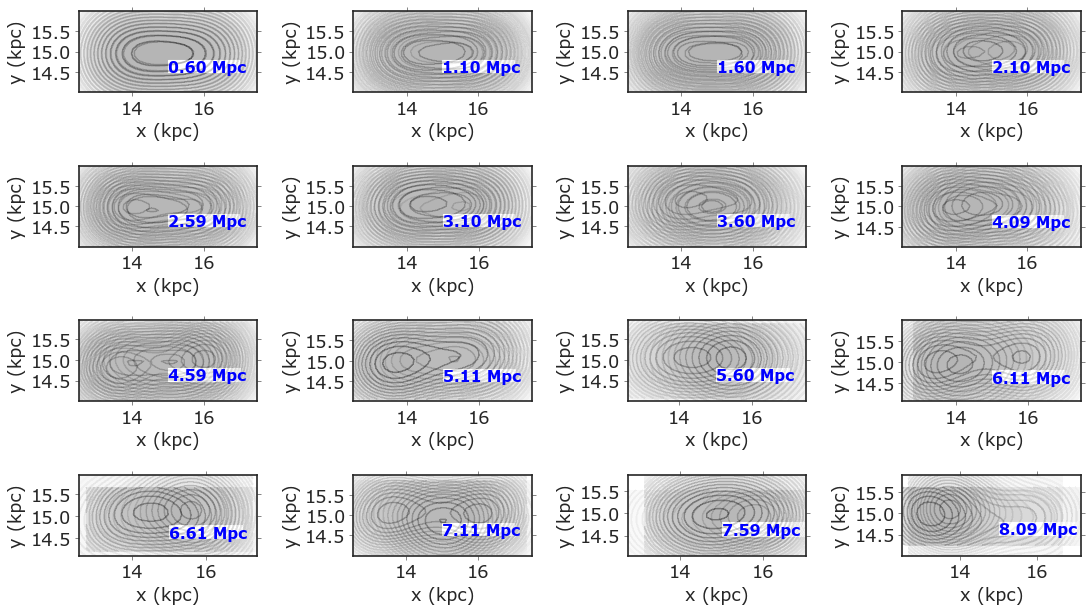

In [46]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.5) ])

resx_all=[get_pipeline_results_full(dmod, 28.69, '10_20', bwu=1.) for dmod in dmods]

resx_all_ids= [x for x in range(len(resx_all)) if len(resx_all[x])>0][::5]


fig, ax=plt.subplots(ncols=4, nrows=int(len(resx_all_ids)/4), figsize=(14, 2*int(len(resx_all_ids)/4)))

axs= np.concatenate(ax)

for idx, idy in zip(range(len(axs)), resx_all_ids):
        a=axs[idx]
        dmod=dmods[idy]
        resx= np.random.choice(resx_all[idy], 20, replace=True)

        for res in resx:
            _=show_gap_detection(res, GAP_SIZES['10_20'],  plot='density', ax=a, alpha=0.1/len(resx))
        title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))

        rect = patches.Rectangle( (15,14.5), \
                                   2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
        a.add_patch(rect)
        a.text(15, 14.5, title,\
               color='b', alpha=1, fontsize=14, weight='bold')
        a.set(xlabel='x (kpc)', ylabel='y (kpc)')

    #ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15_densityonly1.jpeg')

del resx_all

In [47]:
#resx_all_ids

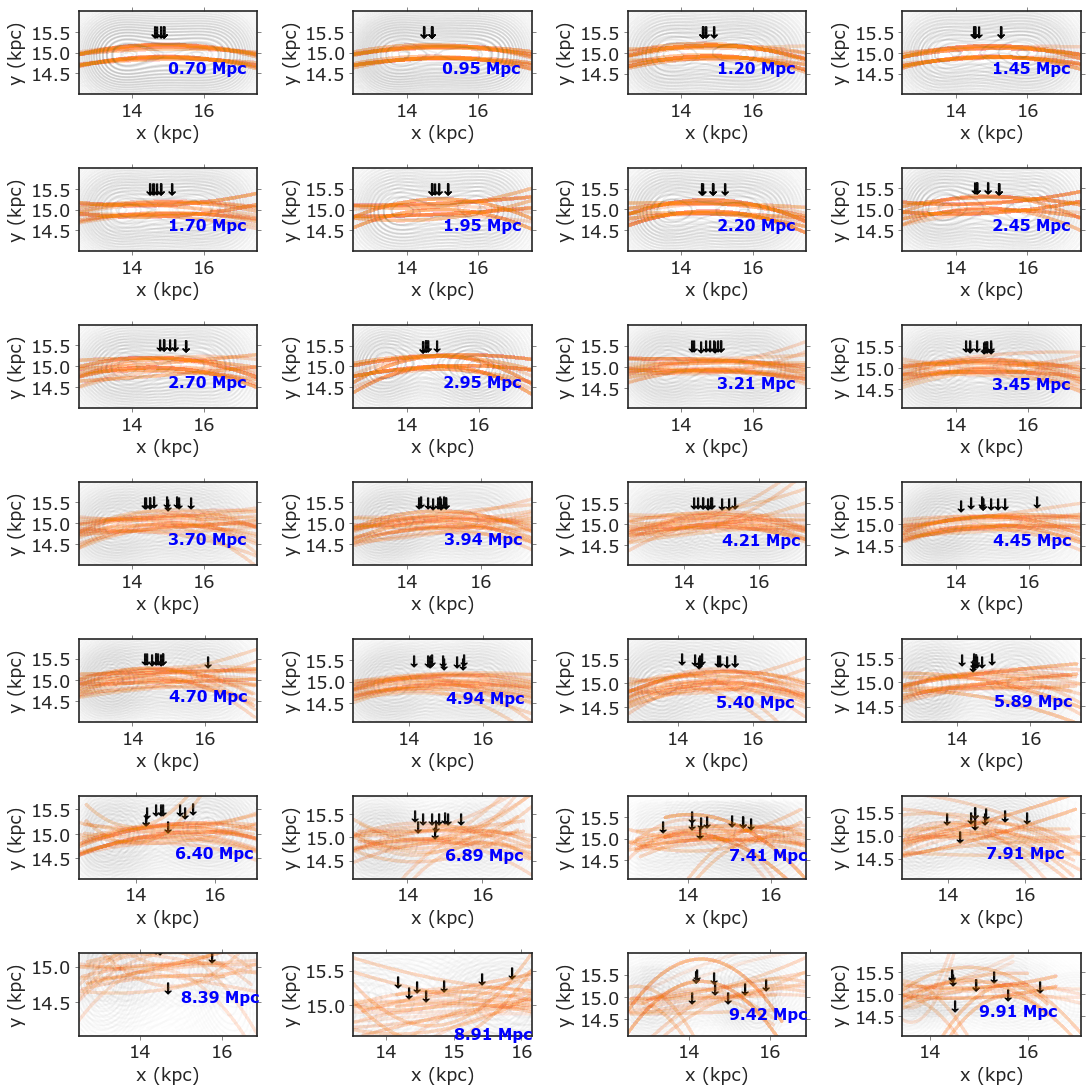

In [48]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.7) ])
dmods=dmods[::5]
len(dmods)

fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    
    resx=np.random.choice(get_pipeline_results_full(dmod, 28.69, '10_20'), 10)
    for res in resx:
        _=show_gap_detection(res, GAP_SIZES['10_20'],  plot='plot7', ax=a, alpha=0.1/len(resx))
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    del resx
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15.jpeg')

In [ ]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.7) ])
dmods=dmods[::5]

fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    
    resx=np.random.choice(get_pipeline_results_full(dmod, 28.69, '10_20'), 10)
    for res in resx:
        _=show_gap_detection(res, GAP_SIZES['10_20'], plot='plot0', ax=a, alpha=0.1/len(resx))
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.1), \
                               2.2, 0.9, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.text(15, 14.1, 'N={}'.format(len(resx)),\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15_stacks.jpeg')


In [ ]:
np.unique(df.bw)

In [ ]:
df[df.bw==0.7].groupby('dmod').count().median(axis=1).plot()

In [ ]:
fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    #res=get_pipeline_results(dmod, 27.15, '10_20')
    #_=show_gap_detection(res,  plot='plot6', ax=a)
    #resx=get_pipeline_results_full(dmod, 28.69, '10_20')
    resx=np.random.choice(get_pipeline_results_full(dmod, 28.69, '10_20'), 10)
    for res in resx:
        _=show_gap_detection(res, GAP_SIZES['10_20'], plot='plot6', ax=a)
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15_piHpi.jpeg')

In [ ]:
from popsims.plot_tools import plot_annotated_heatmap


In [ ]:
resx_all

In [ ]:

#df['prod']=df.spread_gap_stars/df.spread_stream_stars
df['offset_center']=np.abs(df.offset_center)

In [ ]:
df.shape

In [ ]:
import matplotlib as mpl

In [ ]:
def compute_offset_from_true_width(row):
    true_val=THEORITICAL_STREAM_WIDTHS[row.rgc]
    return np.abs(row.spread_stream_stars_y-true_val)

df['offset_from_true_width']=df.apply(compute_offset_from_true_width, axis=1)

In [ ]:
df=df[np.logical_and(df.bw.between(0.05, 1.7), df.dmod<29.5)]
df['gap_spread']= (df.spread_gap_stars_y**2+df.spread_gap_stars_x**2)**0.5

In [ ]:
#xold = df.dmod

#ax.plot(xold[3:], xnew[3:], label='Transform data')
#ax.set_xlabel('X [m]')
#ax.legend()




In [ ]:
len(bckd)

In [ ]:
def compute_spread(x):
    return np.nanmedian(x)

def get_rgcx(rgc):
    return np.nanmedian(np.array(rgc.split('_')).astype(float))

In [ ]:
df['rgcx']=df.rgc.apply(get_rgcx)
#df['gap_center_spread']=(df.gap_center-df.rgcx).apply(get_std)

In [ ]:
df.columns

In [ ]:
df.offset_center.min()

In [ ]:
fig, ax=plt.subplots(ncols=3, figsize=(14*1.2, 4*1.2))

#ax[0].scatter(  df.dmod, df.bw, c=df.spread_gap_stars , s=0.1, cmap='cubehelix')
#ax[1].scatter(df.dmod, df.bw, c=df.spread_stream_stars, s=0.1, cmap='cubehelix')

cmap0 = mpl.cm.coolwarm_r
norm0 =mpl.colors.LogNorm()

cmap = mpl.cm.coolwarm
norm1 =mpl.colors.LogNorm()#mpl.colors.CenteredNorm(vcenter=0.05)
norm2 =mpl.colors.LogNorm()#CenteredNorm(vcenter=0.5)

plot_annotated_heatmap(ax[0], df, 16, ['dmod', 'bw', 'spread_stream_stars_x'],  norm=norm0,cmap=cmap0,annotate=True,  alpha=0.5)
plot_annotated_heatmap(ax[1], df, 16, ['dmod', 'bw', 'spread_gap_stars_x'], norm=norm1,  cmap=cmap,annotate=False, alpha=0.5)
plot_annotated_heatmap(ax[-1], df, 16, ['dmod', 'bw', 'offset_center'],  norm=norm2, cmap=cmap,annotate=False, alpha=0.5)

#ax[0].scatter(df.dmod, df.bw, s=.1)

xticks=[1., 1.5,  2.]
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm0, cmap=cmap0), ax=ax[0], orientation='vertical', label=r'Spread of Stream Points ($\mathcal{S}_s$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)


xticks=[0.3, 0.4, 0.6, 1., 2.]
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax[1], orientation='vertical', label=r'Spread of Gap Points ($\mathcal{S}_g$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)

cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax[-1], orientation='vertical', label=r'Gap Location from Center ($\Delta$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)

def forward(x):
    return (10**((x/5)+1))/1e6

def inverse(x):
    return  5*np.log10(x*1000/(10))

for a in ax:
    secax = a.secondary_xaxis('top', functions=(forward, inverse))
    secax.set(xlabel='Distance (Mpc)')
    
    a.set( xlabel='Distance Modulus', ylabel='Bandwidth (kpc)', ylim=[0.05, 1.65], xlim=[23.7, 29.35])


plt.tight_layout()


plt.savefig('../figures/gaps_spread_all_bws.pdf', bbox_inches='tight')


In [ ]:
ds=([0.77, 1., 1.5, 2., 2.5, 3.])*u.Mpc
dmods2 = 5*np.log10(ds.to(u.pc)/(10*u.pc)).value

dmods2

In [ ]:
dmods2=[ 24.52,  25.  , 25.88, 26.51, 26.99, 27.39]

In [ ]:
len(df)

In [ ]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    
    res=get_pipeline_results_full(dmod, 28.69, '10_20')[0]
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    #print(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, c='k')
    a.minorticks_on()
    #a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    
    a.hlines(y=14.3, xmin= 13, xmax=13+scaled_arcmin, \
             linewidth=5, color='#FF4136')
    
    rect = patches.Rectangle( (13,14), \
                               1, 0.25, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(13, 14., '5 Arcmin',\
           color='#FF4136', alpha=1, fontsize=14, weight='bold')
    
    a.scatter(14.5,  15.0+0.25, color='b', marker='$\u2193$', s=400)
    
    xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
    ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)', xlim=xlim,
         ylim=ylim)

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections.jpeg')

In [ ]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    
    res=get_pipeline_results_full(dmod, 28.69, '30_40')[0]
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    #print(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.2, c='k')
    a.minorticks_on()
    #a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    
    a.hlines(y=34.3, xmin= 33, xmax=33+scaled_arcmin, \
             linewidth=5, color='#FF4136')
    
    rect = patches.Rectangle( (33,34), \
                               1, 0.25, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(33, 34., '5 Arcmin',\
           color='#FF4136', alpha=1, fontsize=14, weight='bold')
    
    a.scatter(34.5,  35.0+0.25, color='b', marker='$\u2193$', s=200)
    
    xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
    ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)', xlim=xlim,
         ylim=ylim)

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections30_40.jpeg')

In [ ]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    
    res=get_pipeline_results_full(dmod, 28.69, '50_60')[0]
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    #print(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, c='k')
    a.minorticks_on()
    #a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    
    a.hlines(y=54.3, xmin= 53, xmax=53+scaled_arcmin, \
             linewidth=5, color='#FF4136')
    
    rect = patches.Rectangle( (53,54), \
                               1, 0.25, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(53, 54., '5 Arcmin',\
           color='#FF4136', alpha=1, fontsize=14, weight='bold')
    
    a.scatter(54.5,  55.0+0.25, color='b', marker='$\u2193$', s=100)
    
    xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
    ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)', xlim=xlim,
         ylim=ylim)

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections50_60.jpeg')

In [ ]:
#res
#if plot=='show_mask_grid':
res=get_pipeline_results_full(24.52, 28.69, '10_20')[3]
meshgrid=res['meshgrid']

fig, ax=plt.subplots(figsize=(12, 4))



ax.scatter(res['data'][:,0], res['data'][:,1], s=20, alpha=0.1, c='k')
_= show_gap_detection(res, GAP_SIZES['10_20'], plot='show_mask_grid', ax=ax)
#_= show_gap_detection(res,  plot='show_mask_data', ax=ax)

In [ ]:
#
res=get_pipeline_results_full(24.52, 28.69, '10_20')[3]
meshgrid=res['meshgrid']


import matplotlib as mpl

fig, ax=plt.subplots(ncols=3, figsize=(10*1.5, 2.25*1.5))

#ax[-1].scatter(res['data'][:,0], res['data'][:,1], s=0.1, alpha=.5, c='k')
_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax[0])
_= show_gap_detection(res, GAP_SIZES['10_20'], plot='plot2', ax=ax[1])
_= show_gap_detection(res, GAP_SIZES['10_20'], plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.079, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')


cmap = mpl.cm.cubehelix
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.415, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Min Eigenvalue of $\Pi H \Pi$')

for a in ax:
    a.set(xlabel='x(kpc)', ylabel='y (kpc)')
    #a.axis('equal')
plt.tight_layout()

plt.savefig('../figures/stream_cutout.jpeg', bbox_inches='tight')

In [ ]:
#df[df.distance==1e6].dmod
#
res=get_pipeline_results_full(25.0, 28.69, '10_20')[3]
meshgrid=res['meshgrid']

In [ ]:



import matplotlib as mpl

fig, ax=plt.subplots(figsize=(10,4))

ax.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)
plt.savefig('../figures/plot0.jpeg', bbox_inches='tight')


fig, ax=plt.subplots(figsize=(10,4))
ax.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

cmap = mpl.cm.Blues

p= ax.contour(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap=cmap, alpha=0.5, linestyle='--')
p=ax.contourf(res['meshgrid'][0], res['meshgrid'][1],  res['density'],  20, \
                              cmap=cmap, alpha=0.5, linestyle='--')

#norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.119, -0.15, 0.85, 0.1])
#mpl.cm.ScalarMappable(norm=norm, cmap=cmap),

fig.colorbar(p,
             cax=cax, orientation='horizontal', label=r'Normalized Density ')
plt.tight_layout()

plt.savefig('../figures/plot1.jpeg', bbox_inches='tight')


fig, ax=plt.subplots(figsize=(10,4))
ax.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

cmap = mpl.cm.coolwarm
p= ax.contourf(res['meshgrid'][0], res['meshgrid'][1],  res['max_eigen'],  20, \
                              cmap=cmap, alpha=0.5, linestyle='--')

#norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.119, -0.15, 0.85, 0.1])
#mpl.cm.ScalarMappable(norm=norm, cmap=cmap),

fig.colorbar(p,
             cax=cax, orientation='horizontal', label=r'Gap Statistic ')
plt.tight_layout()

plt.savefig('../figures/plot2.jpeg', bbox_inches='tight')


fig, ax=plt.subplots(figsize=(10,4))
ax.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

cmap = mpl.cm.coolwarm
p= ax.contourf(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
                              cmap=cmap, alpha=0.5, linestyle='--')

#norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.119, -0.15, 0.85, 0.1])
#mpl.cm.ScalarMappable(norm=norm, cmap=cmap),

fig.colorbar(p,
             cax=cax, orientation='horizontal', label=r'Stream Statistic ')
plt.tight_layout()

plt.savefig('../figures/plot3.jpeg', bbox_inches='tight')


fig, ax=plt.subplots(figsize=(10,4))
_= show_gap_detection(res, GAP_SIZES['10_20'],  plot='plot4', ax=ax, alpha=0.12, ms=10)
#ax.scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

#cmap = mpl.cm.coolwarm
#p= ax.contourf(res['meshgrid'][0], res['meshgrid'][1],  res['min_eigen'],  20, \
#                              cmap=cmap, alpha=0.5, linestyle='--')

#norm = mpl.colors.Normalize(vmin=0, vmax=1)
#cax = fig.add_axes([0.119, -0.15, 0.85, 0.1])
#mpl.cm.ScalarMappable(norm=norm, cmap=cmap),

#fig.colorbar(p,
#             cax=cax, orientation='horizontal', label=r'Stream Statistic ')
plt.tight_layout()

plt.savefig('../figures/plot4.jpeg', bbox_inches='tight')



In [ ]:
#appendidx figures
#plt.rcParams.update({'font.size': 42})
fig, ax=plt.subplots(figsize=(18,4), ncols=3)


res=get_pipeline_results_full(25.0, 28.69, '10_20', bwu=1.5)[0]
#print(res)
meshgrid=res['meshgrid']

ax[0].scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

_= show_gap_detection(res, GAP_SIZES['10_20'], plot='plot1', ax=ax[1])
#_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([.4, -0.0, 0.25, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

_= show_gap_detection(res, GAP_SIZES['10_20'], plot='plot4', ax=ax[-1], alpha=0.12, ms=10)

for a in ax:
    a.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.tight_layout()
plt.savefig('../figures/appendix_failure0.jpeg', bbox_inches='tight')


In [ ]:
#appendidx figures
#plt.rcParams.update({'font.size': 42})
fig, ax=plt.subplots(figsize=(18,4), ncols=3)


res=get_pipeline_results_full(25.0, 28.69, '10_20', bwu=0.1)[0]
#print(res)
meshgrid=res['meshgrid']

ax[0].scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.12, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax[1])
#_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([.4, -0.0, 0.25, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot4', ax=ax[-1], alpha=0.12, ms=10)

for a in ax:
    a.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.tight_layout()
plt.savefig('../figures/appendix_failure1.jpeg', bbox_inches='tight')


In [ ]:
#appendidx figures
#plt.rcParams.update({'font.size': 42})
fig, ax=plt.subplots(figsize=(18,4), ncols=3)


res=get_pipeline_results_full(28.49, 28.69, '10_20', bwu=0.7)[0]
#print(res)
meshgrid=res['meshgrid']

ax[0].scatter(res['data'][:,0], res['data'][:,1], s=10, alpha=0.2, color='k')
xlim=[np.nanmin(res['data'][:,0]), np.nanmax(res['data'][:,0])]
ylim=[np.nanmin(res['data'][:,1]), np.nanmax(res['data'][:,1])]
ax[0].set(xlabel='X (kpc)', ylabel='Y (kpc)', xlim=xlim, ylim=ylim)

_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax[1])
#_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([.4, -0.0, 0.25, 0.05])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')

xyz= show_gap_detection(res,GAP_SIZES['10_20'],  plot='plot4', ax=ax[-1], alpha=0.2, ms=10)

for a in ax:
    a.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.tight_layout()
plt.savefig('../figures/appendix_failure2.jpeg', bbox_inches='tight')


In [ ]:
xyz

In [ ]:
hbj

In [ ]:
def get_nsimulated(mlimit):
    
    from popsims import sample_from_powerlaw
    import scipy.interpolate as interp
    path_isochrone='../data/isochrones/'
    isochrone_path=path_isochrone
    mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']
    from scipy.interpolate import interp1d, griddata
    from tqdm import tqdm
    
    
    def count_pal5_stars_old(mag_limit, dmod):
            dmod_pal5=16.85
            cfht_mini = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
            cfht_gmag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
            cfht_imag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
            wfirst_mini = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
            wfirst_mags = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

            sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(1e6)) 
            inter_gmags = interp.interp1d(cfht_mini, cfht_gmag, bounds_error=False,  fill_value=np.nan)
            inter_imags = interp.interp1d(cfht_mini, cfht_imag, bounds_error=False,  fill_value=np.nan)
            inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0], bounds_error=False,  fill_value=np.nan)
            inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1], bounds_error=False,  fill_value=np.nan)
            inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2], bounds_error=False,  fill_value=np.nan)
            inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3], bounds_error=False,  fill_value=np.nan)
            inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4], bounds_error=False,  fill_value=np.nan)
            inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5], bounds_error=False,  fill_value=np.nan)
            inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6], bounds_error=False,  fill_value=np.nan)

            if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
                print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
            else:    
                #CFHT magnitudes
                sample_gmags = inter_gmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
                sample_imags = inter_imags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
                #WFIRST magnitudes
                sample_Rmags = inter_Rmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
                sample_Zmags = inter_Zmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
                sample_Ymags = inter_Ymags(sample_lowmasses)  +  dmod_pal5 
                sample_Jmags = inter_Jmags(sample_lowmasses)+  dmod_pal5  #distance modulus Pal5
                sample_Hmags = inter_Hmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
                sample_Fmags = inter_Fmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
                sample_Wmags = inter_Wmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5

                #renormalize the luminosity function by computing a normalization factor
                num_20_23= len(sample_gmags[np.logical_and(sample_gmags>=20, sample_gmags<=23)])
                #print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))

                norm= 3000/num_20_23
                #print (norm)

                #compute the difference between distance moduli and offset stars
                dist_mod_And = dmod-dmod_pal5
                #offset_Zmags= sample_Zmags+  dist_mod_And
                nstars_wfirst = (len(np.where((sample_Zmags < (mag_limit-dist_mod_And)  ))[0]))*norm

                #fig, ax=plt.subplots()
                #plt.scatter( sample_lowmasses, sample_gmags)
                #ax.set(ylabel=k, xlabel='Mass ')
                #j
                return nstars_wfirst
        
    ns=[]

    ds=np.arange(500, 10000, 50)*u.kpc
    dmods=5*np.log10(ds.to(u.pc).value/10.0)

    for dmod in tqdm(dmods):
        ns.append(count_pal5_stars_old(mlimit, dmod))

    return ns

In [ ]:
ns0=get_nsimulated(28.69)

In [ ]:
ns1=get_nsimulated(27.15)

In [ ]:
#Compare stream numbers to recovered number 

fig, (ax, ax1)=plt.subplots(ncols=2, sharey='row')


for rgc in ['10_20', '30_40', '50_60']:
    mask=np.logical_and.reduce([(df.mag_limit==28.69).values, (df.bw==0.7).values, (df.rgc==rgc).values])
    ax.scatter(df.distance[mask]/1e3, df.nstars_stream[mask], marker='.', c=colors[rgc], s=10)
    ax.plot(np.arange(500, 10000, 50), ns0, c='k', linewidth=3)


    mask=np.logical_and.reduce([(df.mag_limit==27.15).values, (df.bw==0.7).values, (df.rgc==rgc).values])
    ax1.scatter(df.distance[mask]/1e3, df.nstars_stream[mask], marker='.',  c=colors[rgc],s=10)
    ax1.plot(np.arange(500, 10000, 50), ns1, c='k', linewidth=3)


for a in (ax, ax1):
    #a.axvline(0.77e3)
    a.legend()
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')
    
ax.set(ylabel='# stream stars')
ax1.set(ylabel='# stream stars')
plt.tight_layout()
plt.savefig('../figures/diagnostic_counts.jpeg', bbox_inches='tight')

In [ ]:
def count_background_stars_in_same_area(row):
    dmod=row.dmod
    mag_limit=row.mag_limit
    rgc= row.rgc
    st_area= row.stream_area
    x=read_backgrounds_file(mag_limit,rgc)
    return np.nanmedian(x[x['dmod']==dmod]['density'].values)*st_area
    

df['nbck_in_stream_area']= df.apply(count_background_stars_in_same_area, axis=1)

In [ ]:
fig, ax=plt.subplots(figsize=(12, 10), ncols=2, nrows=2,  height_ratios=[1.,  0.5])


for rgc in ['10_20', '30_40', '50_60']:
    
    a= ax[0][0]
    #rgc='10_20'
    mask=np.logical_and.reduce([(df.mag_limit==28.69).values, (df.bw==0.7).values, (df.rgc==rgc).values])
    a.scatter(df.distance[mask]/1e3, df.nstars_stream[mask], marker='.', c=colors[rgc], s=10,
             alpha=0.3)
    #ax.plot(np.arange(500, 10000, 50), ns0, c='k', linewidth=3)
    #a.scatter(df.distance[mask]/1e3, df.nbck_in_stream_area[mask], marker='^', c='r', s=10)
    #a.axvline(0.77e3)
    a.legend()
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')

    a.set(ylabel='# stream stars')

    a=ax[1][0]
    a.scatter(df.distance[mask]/1e3, np.abs(df.nstars_stream[mask]/df.nbck_in_stream_area[mask]), \
              marker='.', c=colors[rgc], s=10, alpha=0.3)
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')
    
    
    
    a= ax[0][1]
    #rgc='10_20'
    mask=np.logical_and.reduce([(df.mag_limit==27.15).values, (df.bw==0.7).values, (df.rgc==rgc).values])
    a.scatter(df.distance[mask]/1e3, df.nstars_stream[mask], marker='.', alpha=0.3, c=colors[rgc], s=10)
    #ax.plot(np.arange(500, 10000, 50), ns0, c='k', linewidth=3)
    #a.scatter(df.distance[mask]/1e3, df.nbck_in_stream_area[mask], marker='^', c='r', s=10)
    #a.axvline(0.77e3)
    a.legend()
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')

    a.set(ylabel='# stream stars')

    a=ax[1][1]
    a.scatter(df.distance[mask]/1e3, np.abs(df.nstars_stream[mask]/df.nbck_in_stream_area[mask]), marker='.', \
              c=colors[rgc], s=10, alpha=0.3)
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')



In [ ]:
for dmod in np.unique(df.dmod.values):
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    print ('galaxy {:.2f}  roman FOV {:.1f} '.format(d_galaxy.to(u.Mpc), roman_fov))

In [ ]:
x[:4]